# Need to install and import necessary libraries

In [1]:
# !pip install numpy
# !pip install matplotlib
# !pip install pandas
# !pip install rich
# !pip install networkx

In [2]:
# Start by importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
import pandas as pd
import math
import pickle
import os
from collections import defaultdict
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
from rich import print

# Defining Nodes and Edges for Graph Visualization

In [3]:
# Need a way to represent the graph easily so that the algorithm can be implemented
# I will use a dictionary tp represent the graph
# The keys will be the nodes and the values will be adjacent nodes
# The graph will be undirected and weighted

nodes = ['A', 'B', 'C', 'D', 'E', 'F']
edges = {
    ('A', 'B'): 3,
    ('A', 'E'): 1,
    ('A', 'C'): 6,
    ('B', 'C'): 5,
    ('B', 'D'): 9,
    ('C', 'D'): 7,
    ('C', 'F'): 11,
    ('D', 'E'): 2,
    ('E', 'F'): 3,
    ('F', 'B'): 2
}

# Need a way to print the graph so that it is easy to visualize using networkx


In [4]:
# Need a way to print the graph so that it is easy to visualize using networkx
def print_graph(nodes, edges, layout=nx.shell_layout, save=False, filename='graph.png'):
    G = nx.Graph()
    G.add_nodes_from(nodes)
    for (u, v), weight in edges.items():
        G.add_edge(u, v, weight=weight)

    pos = layout(G)  # Get the position layout for nodes
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=8, font_weight='bold')

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    # If save is true, save the graph
    if save:
        plt.savefig(f'mst graphs/{filename}', dpi=600)

    plt.show()

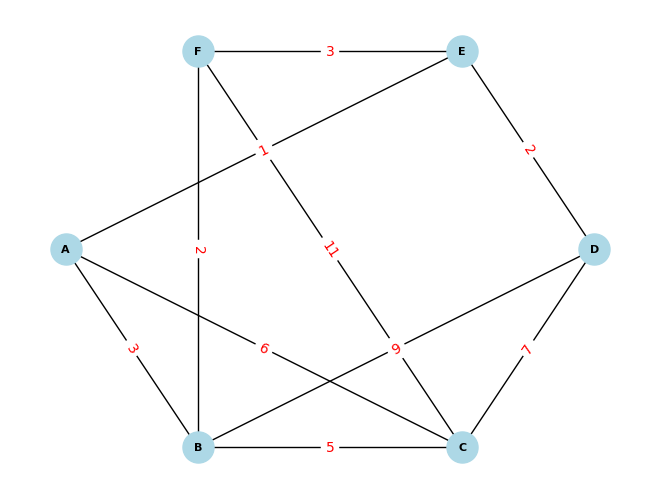

In [5]:
# Print the graph defined above
print_graph(nodes, edges, save=True, filename='graph_no_mst.png')

# Implementing Boruvka's Algorithm for Minimum Spanning Tree with Animation

In [6]:

def boruvka(nodes, edges, animation=False, progress=False, file_name='boruvka.gif'):
    # Initialize each node as its own separate component
    sets = {node: node for node in nodes}  
    mst = {}  # Dictionary to store the minimum spanning tree

    if animation:
        frames = []  # List to store frames for animation
        frames.append(create_frame(nodes, edges, mst).copy())

    # Heap to store all edges in the order of their weights
    edge_heap = []
    for edge, weight in edges.items():
        heapq.heappush(edge_heap, (weight, edge))

    # Print progress message if required
    if progress:
        print("Running Boruvka's Algorithm...")

    # Initialize progress bar for visual feedback
    progress_bar = tqdm(total=len(nodes) - 1, desc='Progress', disable=not progress)

    # Run the algorithm until the MST has n-1 edges
    while len(mst) < len(nodes) - 1:
        min_edges = {}  # Store minimum edge for each component

        # Iterate through the heap to find the minimum weight edge for each component
        for weight, (node1, node2) in edge_heap:
            set1, set2 = sets[node1], sets[node2]
            if set1 != set2:
                # Update minimum edge for the component if a smaller one is found
                if set1 not in min_edges or weight < min_edges[set1][0]:
                    min_edges[set1] = (weight, (node1, node2))
                if set2 not in min_edges or weight < min_edges[set2][0]:
                    min_edges[set2] = (weight, (node1, node2))

        # Merge components and add edges to the MST
        for weight, (node1, node2) in min_edges.values():
            set1, set2 = sets[node1], sets[node2]
            edge = None
            if set1 != set2:
                edge = (node1, node2)
                mst[edge] = weight
                # Update the component set for the merged components
                new_set = min(set1, set2)
                for node in sets:
                    if sets[node] == set1 or sets[node] == set2:
                        sets[node] = new_set
                # Update progress bar after each merge
                progress_bar.update(1)
                
                if animation:
                    # Create a snapshot of the current graph state and add it to frames
                    frames.append(create_frame(nodes, edges, mst, individual_edge=edge, individual_weight=weight, info=f"Edge {set1} -> {set2} added to MST").copy())

    # Close the progress bar when done
    progress_bar.close()

    # If animation is enabled, save the animation
    if animation:
        # Add a final frame to show the final MST
        frames.append(create_frame(nodes, edges, mst, info='Minimum Spanning Tree').copy())
        save_animation(frames, file_name)

    return mst  # Return the minimum spanning tree

def create_frame(nodes, edges, mst, individual_edge=None, individual_weight=None, info=None):
    # Initialize a new graph for the frame
    frame = nx.Graph()
    # Add nodes to the frame
    frame.add_nodes_from(nodes)
    # Store the specific edge that is being added to the MST
    frame.graph['info'] = info

    # Iterate through all edges to construct the frame
    for edge, weight in edges.items():
        # Check if the edge is part of the MST and set its attributes
        if edge in mst:
            # Edges in the MST are colored blue and made thicker
            frame.add_edge(edge[0], edge[1], weight=weight, color='blue', width=2)
        else:
            # Edges not in the MST are red
            frame.add_edge(edge[0], edge[1], weight=weight, color='red', width=0.1)
    
    # Highlight an individual edge if specified (used in animation for showing the edge being processed)
    if individual_edge:
        frame.add_edge(individual_edge[0], individual_edge[1], weight=individual_weight, color='green', width=2)

    return frame

def update_graph(num, frames, G, pos, ax):
    # Clear the current axes to draw the new frame
    ax.clear()
    # Retrieve the frame to be drawn
    frame = frames[num]

    # Extract color and width attributes for all edges in the frame
    colors = nx.get_edge_attributes(frame, 'color').values()
    widths = nx.get_edge_attributes(frame, 'width').values()
    # Draw the graph using these attributes
    nx.draw(frame, pos, edge_color=colors, width=list(widths), with_labels=True, ax=ax)

    # Draw labels on MST edges to show their weights
    edge_labels = {(u, v): data['weight'] for u, v, data in frame.edges(data=True) if data['width'] == 2}
    nx.draw_networkx_edge_labels(frame, pos, edge_labels=edge_labels, ax=ax, font_size=8)

    # If additional information is provided, add it as text annotation on the graph
    info = frame.graph.get('info')
    if info:
        ax.text(0.5, 1.05, info, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)

def save_animation(frames, filename):
    # Create a figure and axes for the animation
    fig, ax = plt.subplots()
    # Initialize a graph for layout purposes
    G = nx.Graph()
    G.add_nodes_from(frames[0].nodes())
    # Determine the layout of the graph
    pos = nx.shell_layout(G)

    # Create an animation by updating the graph for each frame
    ani = FuncAnimation(fig, update_graph, frames=len(frames), fargs=(frames, G, pos, ax), interval=1000, repeat_delay=1000)
    # Save the animation to a file
    ani.save(f"animation/{filename}", writer='pillow', dpi=400)
    # Also save a static version of the final frame
    plt.savefig(f'animation/{filename.split(".")[0]}.png', dpi=800)
    # Close the plot to free resources
    plt.close(fig)

In [7]:
from IPython.display import Image, display
import time

timestamp = int(time.time())

## Run boruvka's algorithm on the graph above

In [8]:
# Run the algorithm
mst = boruvka(nodes, edges, animation=True, file_name=f'boruvka_{timestamp}.gif')

In [9]:
# Output the MST
mst

{('A', 'E'): 1, ('D', 'E'): 2, ('B', 'C'): 5, ('F', 'B'): 2, ('A', 'B'): 3}

## Outputting both the original graph and the corresponding minimum spanning tree using the print_graph function defined above

Original Graph

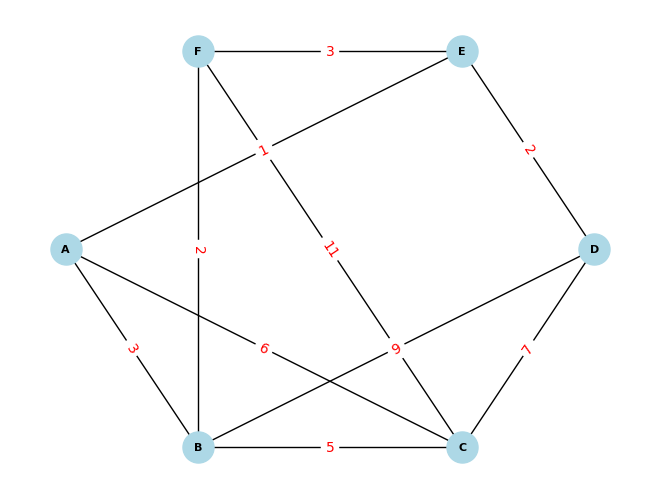

Minimum Spanning Tree

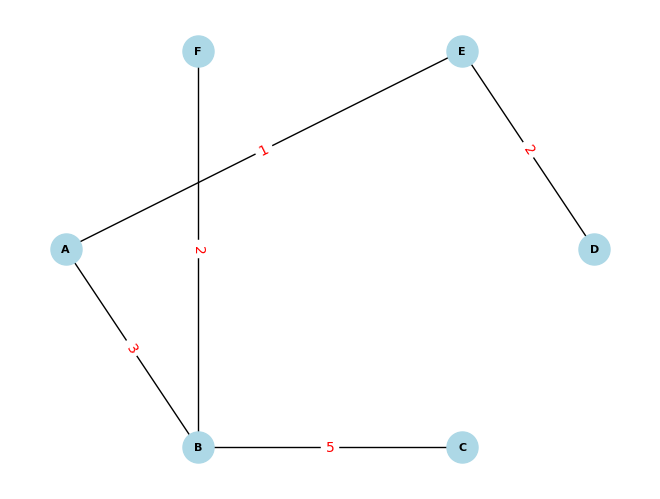

In [10]:
# Print the original graph using the print_graph function defined above
print('[bold]Original Graph')
print_graph(nodes, edges)

# Print the MST using the print_graph function defined above
print('[bold]Minimum Spanning Tree')
print_graph(nodes, mst, save=True, filename='mst_simple.png')

In [11]:
display(Image(url=f"animation/boruvka_{timestamp}.gif", width=800, height=600))

# Creating a Random Connected Graph


In [12]:
# Generate a random graph
import random

# Function to create a random connected graph with n nodes and m edges
def generate_random_connected_graph(n, m):
    # Generate node names (e.g., 'A', 'B', 'C', ..., 'Z', 'AA', 'AB', ...)
    nodes = [chr(65 + i) if i < 26 else chr(64 + i // 26) + chr(65 + i % 26) for i in range(n)]

    # Ensure the graph is connected by creating a path that visits each node once
    # Shuffle the nodes to ensure the path is random
    shuffled_nodes = random.sample(nodes, n)
    # Connect the shuffled nodes with edges
    edges = {(shuffled_nodes[i], shuffled_nodes[i + 1]): random.randint(1, 10) for i in range(n - 1)}

    # Create all possible edges between nodes except the ones already in the path
    all_possible_edges = [(nodes[i], nodes[j]) for i in range(n) for j in range(i+1, n) if (nodes[i], nodes[j]) not in edges]

    # Randomly select additional edges to add, ensuring not to exceed m or the number of remaining possible edges
    additional_edges_count = min(m - (n - 1), len(all_possible_edges))
    if additional_edges_count > 0:
        additional_random_edges = random.sample(all_possible_edges, additional_edges_count)
        # Assign a random weight to each additional edge
        additional_edges = {edge: random.randint(1, 10) for edge in additional_random_edges}
        # Add the additional edges to the graph
        edges.update(additional_edges)

    return nodes, edges

n = 10
m = 25
# Initialize the graph with n nodes and m edges
nodes, edges = generate_random_connected_graph(n, m)

In [13]:
# Small function to print the number of edges in the graph in a nice format
def print_edges_table(edges):
    # Create the DataFrame with edges as index
    df = pd.DataFrame.from_dict(edges, orient='index', columns=['Weight'])
    # Reset the index to get the edges as a column
    df.reset_index(inplace=True)
    # Rename the columns appropriately
    df.columns = ['Edges', 'Weight']
    df.index = np.arange(1, len(df) + 1)
    return df

# Print the number of edges in the graph
print_edges_table(edges)

,Edges,Weight
1,"(E, B)",7
2,"(B, H)",6
3,"(H, F)",10
4,"(F, C)",8
5,"(C, J)",4
6,"(J, G)",1
7,"(G, D)",3
8,"(D, A)",5
9,"(A, I)",4
10,"(I, J)",10


## Running the algorithm on the random graph

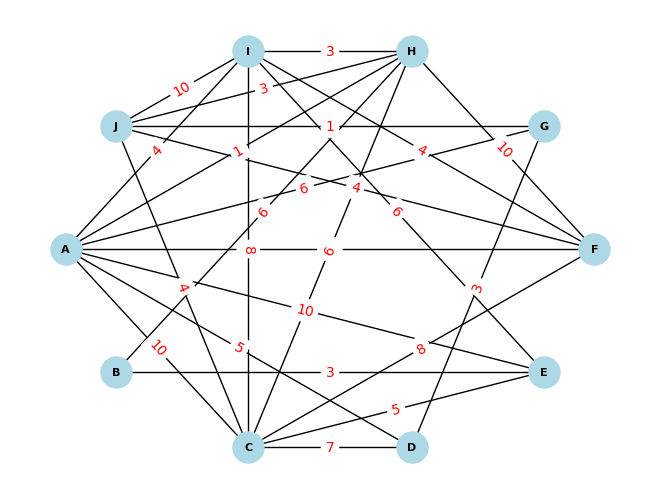

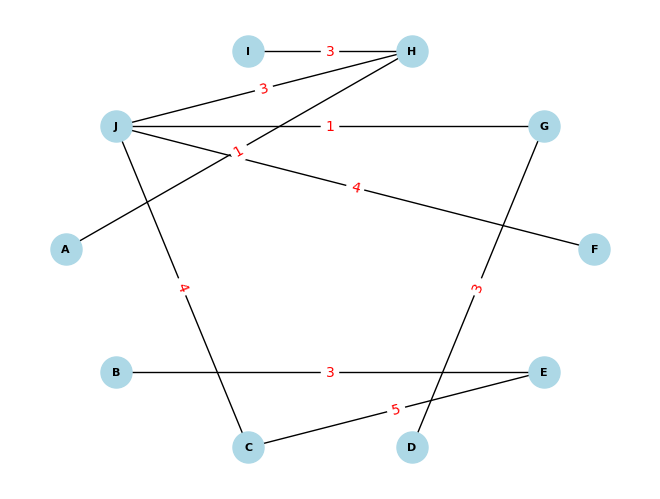

In [14]:
# Run the algorithm on the random graph

# Define a layout so it stays consistent across outputs
layout = nx.shell_layout
# Print the original graph
print_graph(nodes, edges, layout=layout, save=True, filename='random_graph.png')

mst = boruvka(nodes, edges, animation=True, file_name=f'Bigger_example_{timestamp}.gif')
print_graph(nodes, mst, layout=layout, save=True, filename='Bigger_example.png')

In [15]:
display(Image(url=f"animation/Bigger_example_{timestamp}.gif", width=800, height=600))

In [16]:
# Print the weight of the original graph and the MST
print(f'Original Graph Weight: {sum(edges.values())}')
print(f'MST Weight: {sum(mst.values())}')

Original Graph Weight: 143

MST Weight: 27

In [17]:
# Boruvka's Algorithm can also be used to create a perfect maze
# A perfect maze is a maze that has no loops and no isolated walls
# I will use the same algorithm, but I will change the graph so that it is a maze

def plot_maze(maze):
    # Assuming 'maze' is a 2D NumPy array where walls are represented by 1s and paths by 0s
    cmap = mcolors.ListedColormap(['white', 'black'])  # white for paths, black for walls
    plt.figure(figsize=(10, 10))
    plt.imshow(maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Turn off the axis
    plt.show()
    

In [18]:
def apply_gradient(maze):
    # Apply a gradient to the path (2) in the maze.

    # Find the coordinates of the path cells in the maze
    path_indices = np.argwhere(maze == 2)

    # Create a gradient of values from 0 to 1
    n = len(path_indices)
    gradient = np.linspace(0, 1, n)

    # Apply the gradient to the path cells in the maze
    for i, (r, c) in enumerate(path_indices):
        maze[r, c] = gradient[i] + 2  # Offset by 2 to distinguish from walls and open paths

    return maze

def plot_maze(maze):
    # Apply gradient to the maze
    gradient_maze = apply_gradient(maze.copy())

    # Determine color mapping based on the values in the maze
    if np.array_equal(np.unique(maze), np.array([0, 1])):
        cmap = mcolors.ListedColormap(['white', 'black'])
    else:
        # Define a custom colormap for different elements of the maze
        cmap = mcolors.LinearSegmentedColormap.from_list('maze_cmap', ['white', 'black', 'blue', 'red'])
        bounds = [0, 1, 2, 3]
        norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Plot the maze with the specified colormap
    plt.figure(figsize=(10, 10))
    plt.imshow(gradient_maze, cmap=cmap, interpolation='none')
    plt.axis('off')  # Hide the axis
    plt.show()


# Define the size of the maze
size = 20
nodes = []

# Initialize nodes spaced evenly throughout the maze
for i in range(0, size, 2):
    for j in range(0, size, 2):
        nodes.append((i, j))

# Initialize the edges dictionary
edges = {}

# Define the boundaries of the maze
min_x = 0
max_x = size - 2
min_y = 0
max_y = size - 2

# Create edges between nodes, ensuring they are within the maze boundaries
for node in nodes:
    x, y = node
    # Define potential adjacent nodes
    adjacent_nodes = [(x+2, y), (x-2, y), (x, y+2), (x, y-2)]
    # Iterate through adjacent nodes and add valid edges
    for adjacent_node in adjacent_nodes:
        if min_x <= adjacent_node[0] <= max_x and min_y <= adjacent_node[1] <= max_y:
            edges[(node, adjacent_node)] = random.randint(1, 10)


In [19]:
maze = boruvka(nodes, edges, progress=True)

Running Boruvka's Algorithm...

Progress: 100%|██████████| 99/99 [00:00<00:00, 57896.83it/s]


In [20]:
def midpoint(x, y):
    # Function to find the midpoint between two values
    return (x + y) // 2

def map_point(p):
    # Function to map a point in the graph to a corresponding point in the numpy array
    return (p[0] * 2, p[1] * 2)

def convert_to_np(nodes, mst, path=None):
    # Convert the minimum spanning tree (MST) to a numpy array for easy visualization.
    # The numpy array format is used to easily print and visualize the graph.

    # Determine the range of x and y coordinates from the nodes
    min_x = min([x[0] for x in nodes])
    max_x = max([x[0] for x in nodes])
    min_y = min([x[1] for x in nodes])
    max_y = max([x[1] for x in nodes])

    # Calculate the size of the numpy array
    size_x = max_x - min_x + 1
    size_y = max_y - min_y + 1

    # Initialize a numpy array with zeros
    np_mst = np.zeros((size_x, size_y))

    # Iterate through each edge in the MST
    for n1, n2 in mst:
        # Mark the nodes in the numpy array
        np_mst[n1] = 1
        np_mst[n2] = 1
        # Find the midpoint of the edge and mark it in the numpy array
        mid_x = midpoint(n1[0], n2[0])
        mid_y = midpoint(n1[1], n2[1])
        np_mst[mid_x][mid_y] = 1        

    # If a path is provided, mark it on the numpy array
    if path:
        for p in path:
            np_mst[p] = 2  # Path is marked with a value of 2

        return np_mst
    else:
        return np_mst

In [21]:
maze

{((0, 6), (0, 8)): 1,
 ((0, 12), (0, 14)): 1,
 ((0, 16), (2, 16)): 1,
 ((0, 12), (2, 12)): 1,
 ((0, 14), (2, 14)): 1,
 ((2, 10), (2, 8)): 1,
 ((6, 4), (4, 4)): 1,
 ((2, 18), (4, 18)): 1,
 ((2, 4), (4, 4)): 1,
 ((8, 10), (8, 8)): 1,
 ((4, 14), (6, 14)): 1,
 ((10, 10), (10, 12)): 1,
 ((2, 12), (4, 12)): 1,
 ((6, 4), (6, 2)): 1,
 ((12, 10), (12, 8)): 1,
 ((4, 0), (4, 2)): 1,
 ((16, 0), (16, 2)): 1,
 ((8, 6), (6, 6)): 1,
 ((4, 10), (2, 10)): 2,
 ((8, 14), (8, 12)): 1,
 ((8, 18), (8, 16)): 1,
 ((10, 2), (10, 4)): 1,
 ((8, 6), (10, 6)): 2,
 ((12, 6), (10, 6)): 3,
 ((0, 10), (2, 10)): 2,
 ((6, 0), (4, 0)): 1,
 ((10, 18), (12, 18)): 1,
 ((12, 4), (14, 4)): 1,
 ((6, 10), (8, 10)): 2,
 ((14, 0), (12, 0)): 1,
 ((14, 4), (16, 4)): 1,
 ((14, 10), (16, 10)): 2,
 ((8, 0), (10, 0)): 1,
 ((14, 16), (12, 16)): 2,
 ((0, 4), (2, 4)): 2,
 ((16, 8), (14, 8)): 1,
 ((16, 8), (16, 6)): 1,
 ((16, 12), (16, 14)): 2,
 ((16, 18), (16, 16)): 2,
 ((18, 4), (18, 6)): 1,
 ((18, 8), (18, 6)): 1,
 ((18, 14), (18, 16)): 

# Visualizing a Maze as a Graph with a Custom Tree Layout

This code snippet is designed to visualize a maze represented as a graph. It emphasizes the structure of the maze by arranging the nodes in a tree-like layout, which is particularly useful for understanding the relationships between different points in the maze. The visualization uses a breadth-first search (BFS) to determine the level of each node relative to a specified root node. This level information is then used to position nodes vertically, creating a clear, hierarchical structure. The code also demonstrates how to highlight the root node, draw weighted edges, and display the graph with custom node sizes and spacing, providing an intuitive and informative view of the maze's layout.


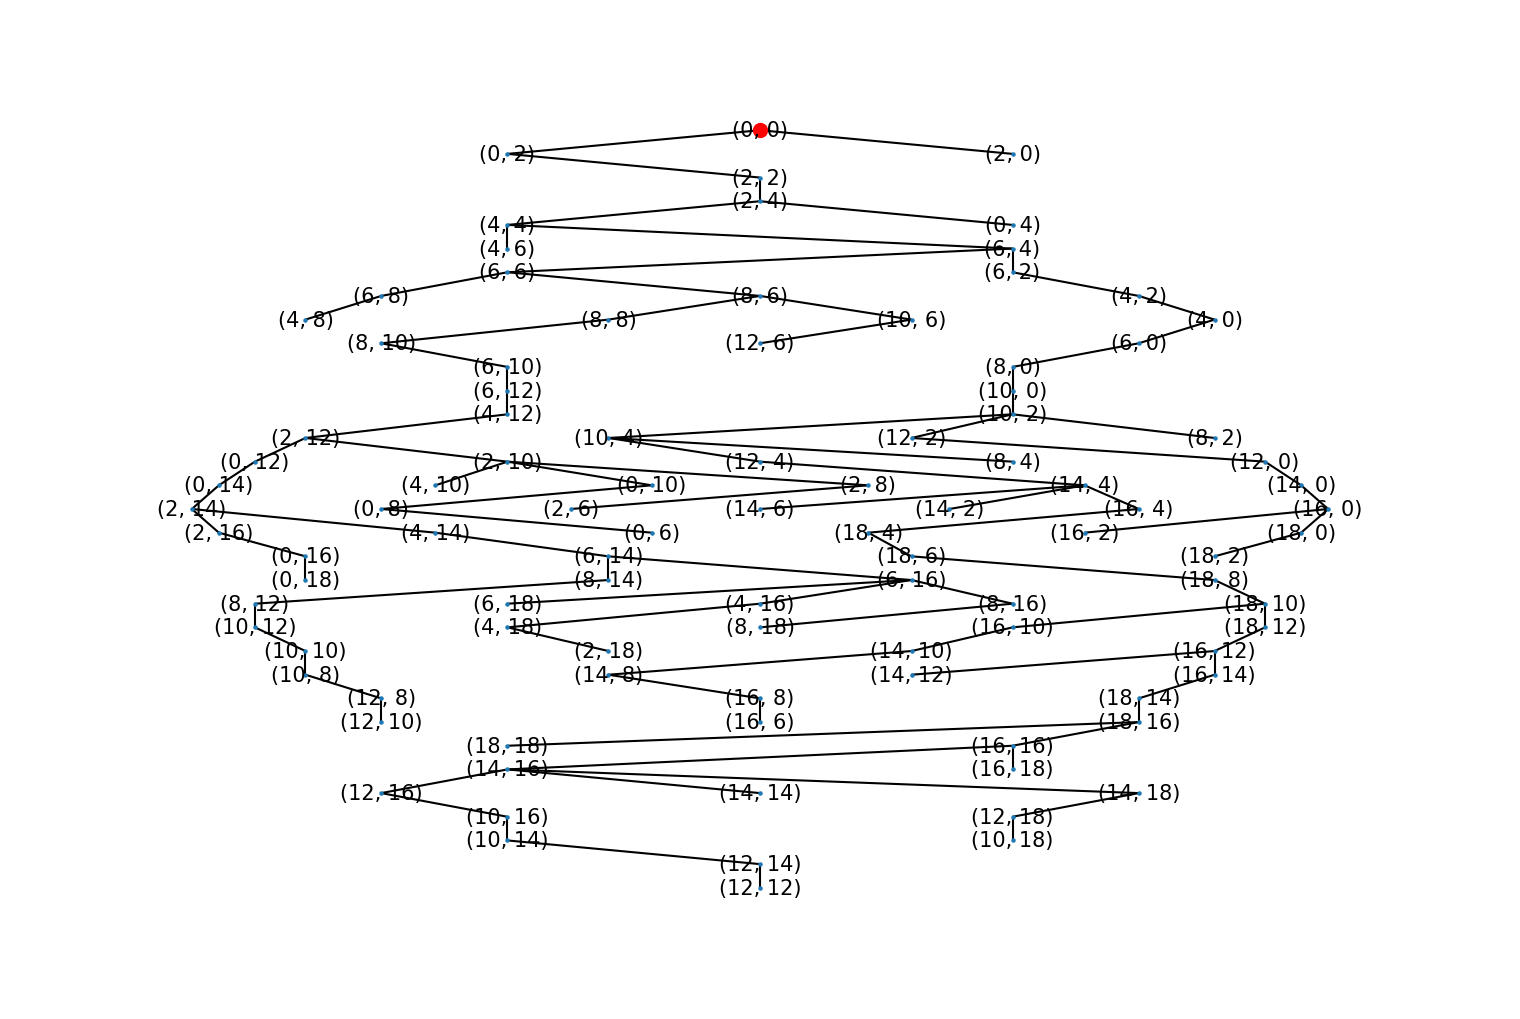

In [22]:
def tree_layout(G, root_node, width=1.0, vert_gap=1.5):
    # Compute the layout for a tree, positioning nodes in levels.

    # Determine levels of each node using BFS
    levels = defaultdict(list)
    queue = [(root_node, 0)]
    while queue:
        node, level = queue.pop(0)
        levels[level].append(node)
        # Add child nodes to the queue
        for child in set(G.neighbors(node)) - set(levels[level - 1]):
            queue.append((child, level + 1))
    
    # Position nodes based on their level and order within the level
    pos = {}
    for level, nodes in levels.items():
        horiz_gap = width / (len(nodes) + 1)
        for i, node in enumerate(nodes):
            pos[node] = ((i + 1) * horiz_gap, -level * vert_gap)
    
    return pos

def print_graph_maze(edges, root_node):
    # Visualize the maze as a graph using a custom tree layout.

    # Initialize a graph and add weighted edges
    G = nx.Graph()
    for (src, dst), weight in edges.items():
        G.add_edge(src, dst, weight=weight)

    # Apply the custom tree layout
    pos = tree_layout(G, root_node)

    # Draw the graph
    plt.figure(figsize=(15, 10))
    nx.draw(G, pos, node_size=5, with_labels=True, font_size=15, width=1.5)
    
    # Highlight the root node
    nx.draw_networkx_nodes(G, pos, nodelist=[root_node], node_size=100, node_color='red')
    plt.margins(0.1)
    plt.show()

# Specify the root node for the maze visualization
root_node = (0, 0)
print_graph_maze(maze, root_node)

In [23]:
def print_maze_nx(edges):
    # Function to visualize a maze as a graph using NetworkX.

    # Initialize a new graph
    G = nx.Graph()
    
    # Add weighted edges to the graph
    for (src, dst), weight in edges.items():
        G.add_edge(src, dst, weight=weight)
    
    # Use the grid coordinates of the maze for positioning the nodes
    # The y-axis is flipped for better alignment with typical maze layouts
    pos = {node: (node[1], -node[0]) for node in G.nodes()}
    
    # Draw the graph using the defined positions
    # Adjust the figure size to be the same as the numpy maze output
    plt.figure(figsize=(7.7, 7.7))
    nx.draw(G, pos, node_size=10, with_labels=True, font_size=12, width=10, font_color='red')
    
    # Adjust margins to prevent clipping of node labels and display the plot
    plt.margins(0.1)
    plt.show()

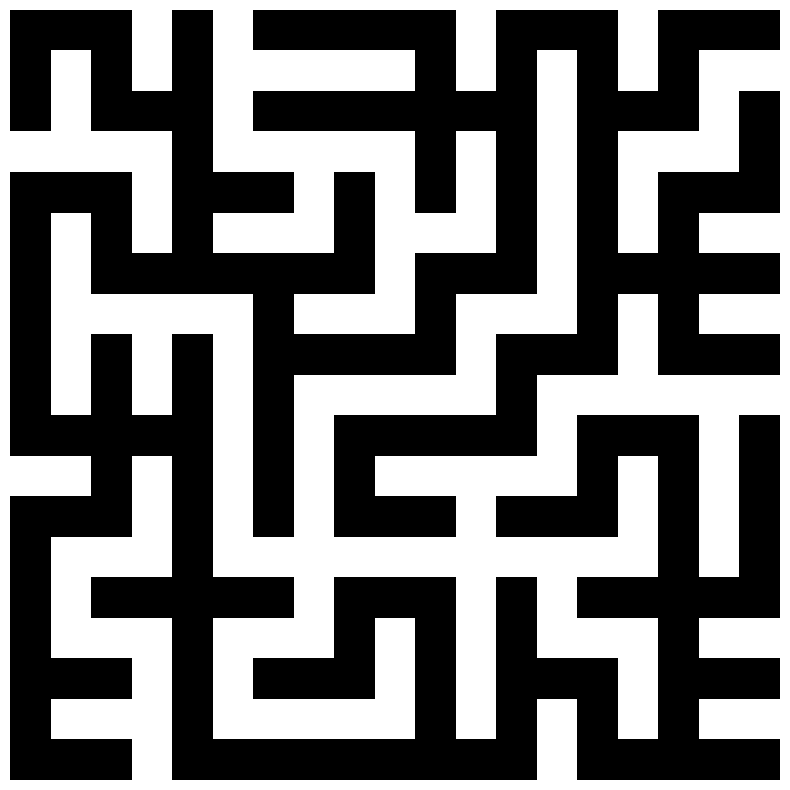

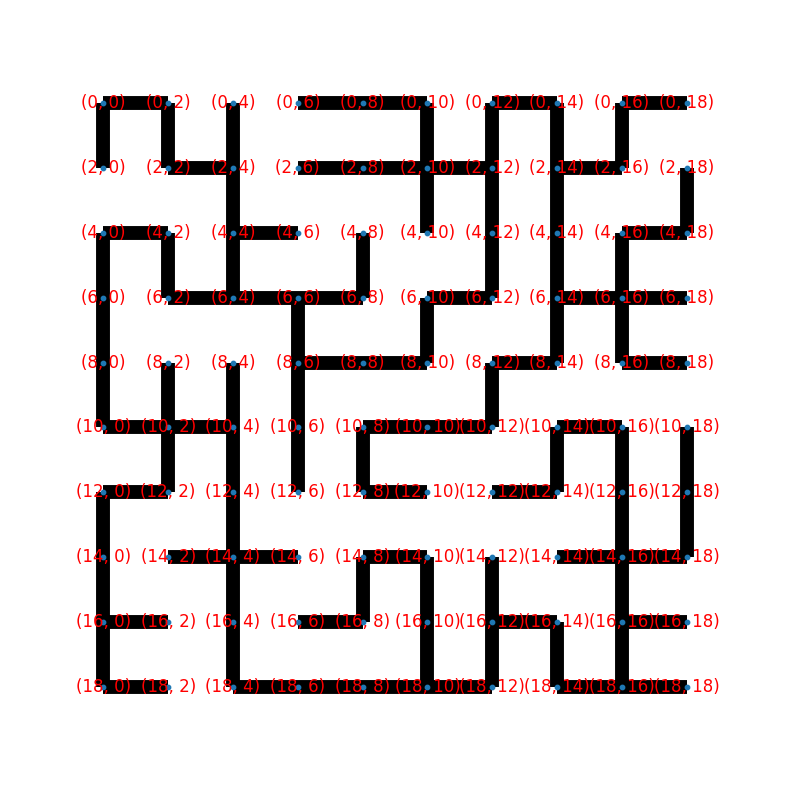

In [24]:
# Convert the maze to a numpy array
np_maze = convert_to_np(nodes, maze)

# Plot the maze using the plot_maze function defined above and the numpy array
plot_maze(np_maze)

# Print the maze as a graph using NetworkX
print_maze_nx(maze)

# Use BFS to get the path from the root node to the bottom right node

In [25]:
def get_neighbours(v, maze):
    # Get the neighboring cells of a given cell in the maze.

    x, y = v

    neighbours = []
    
    # Check horizontal neighbors
    # If the node is on the left edge, only add right neighbor
    if x == 0:
        neighbours.append((x + 1, y))
    # If the node is on the right edge, only add left neighbor
    elif x == maze.shape[0] - 1:
        neighbours.append((x - 1, y))
    # Otherwise, add both left and right neighbors
    else:
        neighbours.append((x + 1, y))
        neighbours.append((x - 1, y))
        
    # Check vertical neighbors
    # If the node is on the top edge, only add bottom neighbor
    if y == 0:
        neighbours.append((x, y + 1))
    # If the node is on the bottom edge, only add top neighbor
    elif y == maze.shape[1] - 1:
        neighbours.append((x, y - 1))
    # Otherwise, add both top and bottom neighbors
    else:
        neighbours.append((x, y + 1))
        neighbours.append((x, y - 1))
        
    return neighbours

def bfs(in_maze):
    # Perform a breadth-first search to find a path from start to end in the maze.

    maze = in_maze.copy()
    Q = []
    
    # Define start and end points
    start = (0, 0)
    end = (maze.shape[0] - 1, maze.shape[1] - 1)
    
    # Initialize queue with start point
    Q.append(start)
    
    # Dictionary to keep track of the path
    prev = {}
    
    # Process nodes in the queue
    while len(Q) > 0:
        v = Q.pop(0)
        
        # If the end is reached, trace back the path
        if v == end:
            return trace_path(prev, end, start)
        
        # Check all neighbors of the current node
        for n in get_neighbours(v, maze):
            # If the neighbor is passable (represented by 1), add it to the queue
            if maze[n] == 1:
                Q.append(n)
                # Mark the neighbor as visited by decreasing its value
                maze[n] = maze[v] - 1
                # Record the path
                prev[n] = v
    
    # Return None if no path is found
    return None

def trace_path(prev, end, start):
    # Trace back the path from end to start using the 'prev' dictionary.
    path = [start]
    current = end
    
    # Trace back from end to start
    while current != start:
        path.append(current)
        current = prev[current]
        
    path.append(current)
    
    # Reverse the path to start from the beginning
    return path[::-1]

# Use the breadth-first search function to find a path through the maze
path = bfs(np_maze)


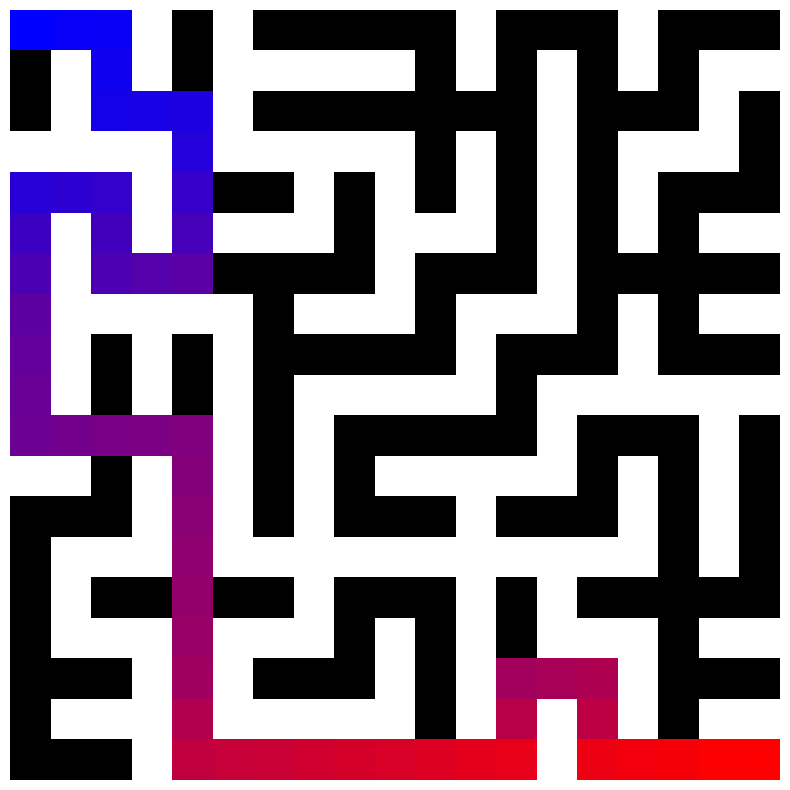

In [26]:
# Plot the maze with the path as a cool gradient
np_maze_with_path = convert_to_np(nodes, maze, path=path)
plot_maze(np_maze_with_path)

In [27]:
# Read text file
data = []

# Data from here:
# 4. City of San Joaquin County (TG) Road Network
# https://users.cs.utah.edu/~lifeifei/research/tpq/TG.cnode
# https://users.cs.utah.edu/~lifeifei/SpatialDataset.htm

file = 'city_of_san_joaquin_county'

# Read in the sata
with open(f'real network data/{file}.txt') as f:
    for line in f:
        data.append(line.split())


# Graph Creation Using Actual City Positions and Nearest Neighbor Connections

This code is designed to create a graph representing cities using their normalised positions from the dataset. It starts by calculating the Euclidean distance between cities, which serves as a basis for establishing connections. Each node in the graph is then connected to its 'n' closest neighboring cities. This approach ensures that the resulting graph realistically models the proximity-based connectivity between different locations. This is done to test the limits of the algorithm and see how to performs on dense graphs. It uses parallel processing to speed up the process of creating the graph and visualizing it.

Because this process can take some time (1 minute for node degree of 30), the code also saves the graph to a file using the pickle library so that it can be loaded and visualized later without having to re-run the code. This is particularly useful for large graphs, which can take a long time to create.

In [28]:
# Function to calculate Euclidean distance between two nodes
def euclidean_distance(node1, node2):
    x1, y1 = node1
    x2, y2 = node2
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# Function to find closest nodes for a given node
def find_closest_nodes(node_index, node_degree, data):
    distances = []
    # Calculate distances from the given node to all other nodes
    for j in range(len(data)):
        if node_index != j:
            dist = euclidean_distance((data[node_index][1], data[node_index][2]), (data[j][1], data[j][2]))
            heapq.heappush(distances, (dist, j))

    closest_nodes = []
    # Get the closest nodes based on the specified degree
    for _ in range(node_degree):
        if distances:
            _, closest_node = heapq.heappop(distances)
            closest_nodes.append((data[node_index][0], data[closest_node][0], distances[0][0]))

    return closest_nodes

# Prepare the data and create a graph
data = [(int(node[0]), float(node[1]), float(node[2])) for node in data]
G = nx.Graph()
# Add nodes with positions to the graph
for node in data:
    G.add_node(node[0], pos=(node[1], node[2]))

# Set the degree of connectivity for each node
node_degree = 30

# Check if the graph has already been created and saved
if f'{file}_graph_{node_degree}.pkl' in os.listdir('graph_pkl'):
    print(f'Graph already created for {file} with node degree {node_degree}')
    # Load the graph if it already exists
    with open(f'graph_pkl/{file}_graph_{node_degree}.pkl', 'rb') as f:
        G = pickle.load(f)
else:
    print(f'Creating graph for {file} with node degree {node_degree}')

    # Parallel processing to find closest nodes
    edges_to_add = []
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(find_closest_nodes, i, node_degree, data) for i in range(len(data))]
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing edges"):
            edges_to_add.extend(future.result())

    # Add edges to the graph
    for edge in edges_to_add:
        G.add_edge(edge[0], edge[1], weight=edge[2])

    # Save the graph for future use
    with open(f'graph_pkl/{file}_graph_{node_degree}.pkl', 'wb') as f:
        pickle.dump(G, f)


Graph already created for city_of_san_joaquin_county with node degree 30

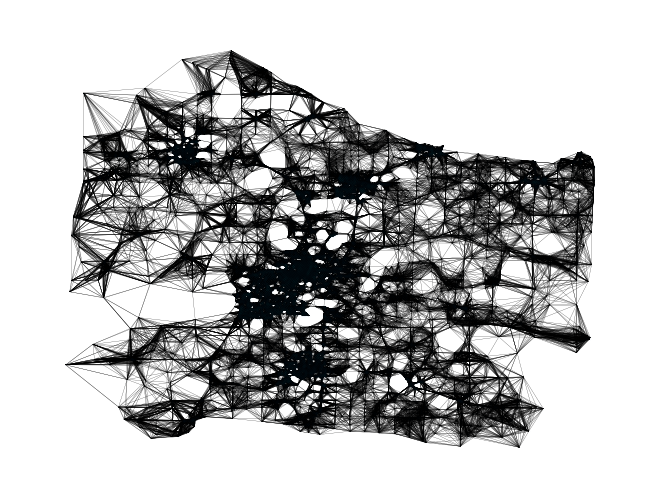

In [29]:
# Output the graph
pos = nx.get_node_attributes(G, 'pos')

# Draw the graph
nx.draw(G, pos, with_labels=False, node_size=.0001, width=.15)
plt.savefig(f'real network data/{file}.png', dpi=1600)
plt.show()

Now That the graph is in the format of a networkx graph it needs to be split into the nodes and edges so it can be passed to my boruvka algorithm. This process also uses pickle to save the nodes and edges to a file so that they can be loaded and used later without having to re-run the code.

In [30]:
# Path to the file
file_path = os.path.join('processed_graphs', file)

# Check if the file already exists
if os.path.exists(file_path):
    print('Loading data from file...')
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    nodes, node_ids, converted_edges = data['nodes'], data['node_ids'], data['converted_edges']
else:
    # Extract nodes and their positions
    print('Extracting nodes and their positions...')
    nodes = {n: (x, y) for n, (x, y) in nx.get_node_attributes(G, 'pos').items()}

    # Convert nodes to a simple list of node IDs
    print('Converting nodes to a simple list of node IDs...')
    node_ids = list(nodes.keys())

    # Extract edges and their weights
    print('Extracting edges and their weights...')
    edges = {edge: G[edge[0]][edge[1]]['weight'] for edge in G.edges()}

    # Convert the edges to use node IDs instead of positions
    print('Converting the edges to use node IDs instead of positions...')
    converted_edges = {(node_ids.index(edge[0]), node_ids.index(edge[1])): weight for edge, weight in tqdm(edges.items(), desc="Converting edges")}


    # Save the processed data to a file
    print('Saving data to file...')
    data = {'nodes': nodes, 'node_ids': node_ids, 'converted_edges': converted_edges}
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)

    print('Done!')


mst = boruvka(node_ids, converted_edges, progress=True)

Loading data from file...

Running Boruvka's Algorithm...

Progress: 100%|██████████| 18262/18262 [00:20<00:00, 871.50it/s]


# Visualise the MST from the dense graph

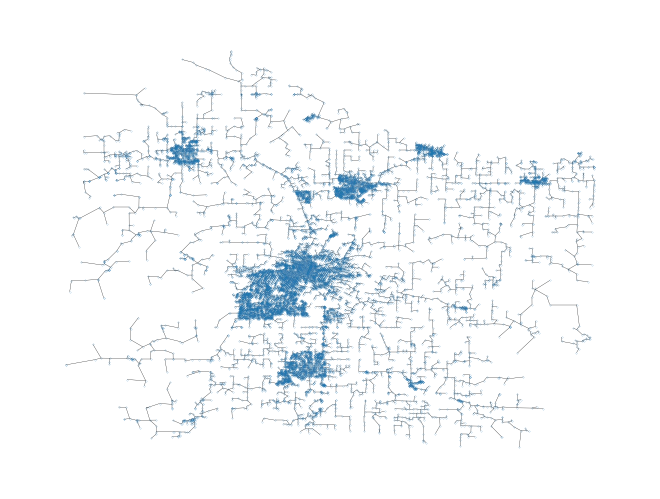

In [31]:
# To visualize the MST, create a new NetworkX graph
mst_graph = nx.Graph()
mst_graph.add_nodes_from(node_ids)
mst_graph.add_edges_from(mst.keys())

# Use original positions for drawing
original_pos = {node_ids[i]: pos for i, pos in enumerate(nx.get_node_attributes(G, 'pos').values())}
nx.draw(mst_graph, original_pos, with_labels=False, node_size=.01, width=.2)
plt.savefig(f'mst graphs/{file.lower()}_mst.png', dpi=1600)
plt.show()

In [32]:
# Get the total weight of the original graph
total_weight = sum(converted_edges.values()) 
print(f'Total weight of original graph: {total_weight}')

# Get the total weight of the MST
mst_weight = sum(mst.values())
print(f'Total weight of MST: {mst_weight}')

Total weight of original graph: 6346350.831345861

Total weight of MST: 576591.4258310515

# Now use the actual edge weights to create a graph from the dataset

In [33]:
# Read in the node data from the file
node_data = []
with open(f'real network data/{file}.txt') as f:
    for line in f:
        node_data.append(line.split())

# Read in the edge data from the file
edge_data = []
with open(f'real network data/{file}_with_edges.txt') as f:
    for line in f:
        edge_data.append(line.split())

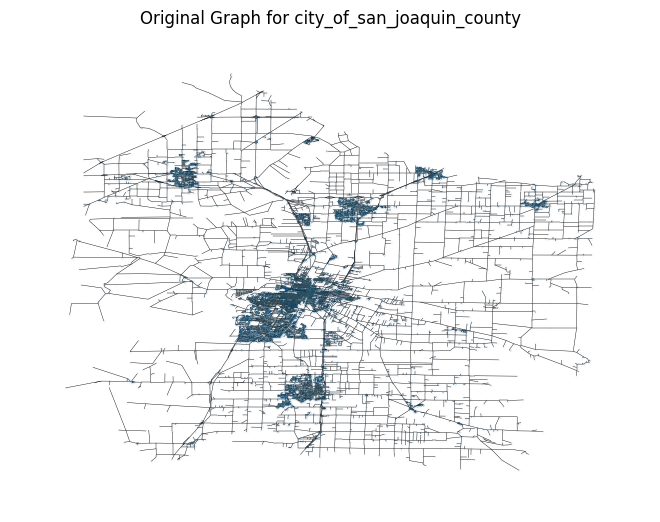

In [34]:
# Create a new networkx graph so it can be drawn
G = nx.Graph()

# Add nodes
for node in node_data:
    node_id, x, y = node
    G.add_node(node_id, pos=(float(x), float(y)))

# Add edges
for edge in edge_data:
    _, source, target, weight = edge
    G.add_edge(source, target, weight=float(weight))

# Draw the graph
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos, with_labels=False, node_size=.001, width=.3)

# Add a title
plt.title(f'Original Graph for {file}')

# Save and show the figure
plt.savefig(f'real network data/{file}_original.png', dpi=1200)
plt.show()

I then need to process the data into a graph that can be used by my algorithm. So I split the data into nodes and edges

In [35]:
# Create node IDs as (x, y) tuples
node_ids = [(float(node[1]), float(node[2])) for node in node_data]

# Create a mapping of node index to (x, y) position
index_to_position = {i: pos for i, pos in enumerate(node_ids)}

# Format edges with position-based node IDs and weights
formatted_edges = {}
for edge in edge_data:
    _, source_index, target_index, weight = edge
    source_pos = index_to_position[int(source_index)]
    target_pos = index_to_position[int(target_index)]
    formatted_edges[(source_pos, target_pos)] = float(weight)

In [36]:
# Run the algorithm
mst = boruvka(node_ids, formatted_edges, progress=True)

Running Boruvka's Algorithm...

Progress: 100%|██████████| 18262/18262 [00:50<00:00, 361.88it/s]


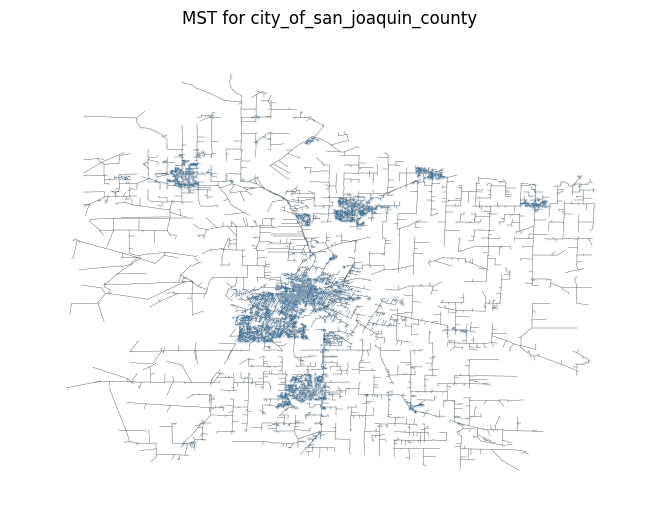

In [37]:
# To visualize the MST, create a new NetworkX graph
mst_graph = nx.Graph()
mst_graph.add_nodes_from(node_ids)
mst_graph.add_edges_from(mst.keys())

# Use original positions for drawing
original_pos = {node_ids[i]: pos for i, pos in enumerate(nx.get_node_attributes(G, 'pos').values())}
nx.draw(mst_graph, original_pos, with_labels=False, node_size=.001, width=.2)
plt.title(f'MST for {file}')
plt.savefig(f'mst graphs/{file.lower()}_mst.png', dpi=1200)

plt.show()

# Now I can compare the weight from the original road data with the actual weights and the MST to see how much the MST has reduced the weight of the graph

In [38]:
# Total weight of the original graph
total_weight = sum(formatted_edges.values())
print(f'Total weight of original graph: {total_weight}')

# Total weight of the MST
mst_weight = sum(mst.values())
print(f'Total weight of MST: {mst_weight}')

# Difference
print(f'Difference: {total_weight - mst_weight}')

Total weight of original graph: 831572.3128279886

Total weight of MST: 531061.6171329985

Difference: 300510.6956949901